In [1]:
import fastf1
from matplotlib import pyplot as plt
import fastf1.plotting

import pandas as pd
import plotly.express as px
from plotly.io import show

from fastf1.ergast import Ergast

import seaborn as sns
from matplotlib import pyplot as plt

## Plot driver standings in a heatmap

In [5]:
ergast = Ergast()
races = ergast.get_race_schedule(2022)  # Races in year 2022
results = []

# For each race in the season
for rnd, race in races['raceName'].items():

    # Get results. Note that we use the round no. + 1, because the round no.
    # starts from one (1) instead of zero (0)
    temp = ergast.get_race_results(season=2022, round=rnd + 1)
    temp = temp.content[0]

    # If there is a sprint, get the results as well
    sprint = ergast.get_sprint_results(season=2022, round=rnd + 1)
    if sprint.content and sprint.description['round'][0] == rnd + 1:
        temp = pd.merge(temp, sprint.content[0], on='driverCode', how='left')
        # Add sprint points and race points to get the total
        temp['points'] = temp['points_x'] + temp['points_y']
        temp.drop(columns=['points_x', 'points_y'], inplace=True)

    # Add round no. and grand prix name
    temp['round'] = rnd + 1
    temp['race'] = race.removesuffix(' Grand Prix')
    temp = temp[['round', 'race', 'driverCode', 'points']]  # Keep useful cols.
    results.append(temp)

# Append all races into a single dataframe
results = pd.concat(results)
races = results['race'].drop_duplicates()

In [6]:
# RE-SHAPE THE DATAFRAME
results = results.pivot(index='driverCode', columns='round', values='points')
# Here we have a 22-by-22 matrix (22 races and 22 drivers, incl. DEV and HUL)

# Rank the drivers by their total points
results['total_points'] = results.sum(axis=1)
results = results.sort_values(by='total_points', ascending=False)
results.drop(columns='total_points', inplace=True)

# Use race name, instead of round no., as column names
results.columns = races

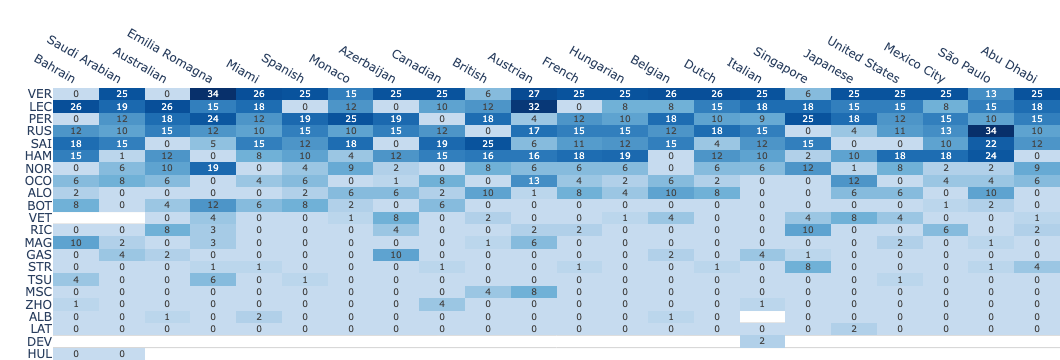

In [7]:
# PLOT
fig = px.imshow(
    results,
    text_auto=True,
    aspect='auto',  # Automatically adjust the aspect ratio
    color_continuous_scale=[[0,    'rgb(198, 219, 239)'],  # Blue scale
                            [0.25, 'rgb(107, 174, 214)'],
                            [0.5,  'rgb(33,  113, 181)'],
                            [0.75, 'rgb(8,   81,  156)'],
                            [1,    'rgb(8,   48,  107)']],
    labels={'x': 'Race',
            'y': 'Driver',
            'color': 'Points'}       # Change hover texts
)
fig.update_xaxes(title_text='')      # Remove axis titles
fig.update_yaxes(title_text='')
fig.update_yaxes(tickmode='linear')  # Show all ticks, i.e. driver names
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGrey',
                 showline=False,
                 tickson='boundaries')              # Show horizontal grid only
fig.update_xaxes(showgrid=False, showline=False)    # And remove vertical grid
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')     # White background
fig.update_layout(coloraxis_showscale=False)        # Remove legend
fig.update_layout(xaxis=dict(side='top'))           # x-axis on top
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))  # Remove border margins
fig
show(fig)

## Team pace comparison

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']


Index(['Red Bull Racing', 'Ferrari', 'McLaren', 'Mercedes', 'Haas F1 Team',
       'Aston Martin', 'Kick Sauber', 'Alpine', 'RB', 'Williams'],
      dtype='object', name='Team')


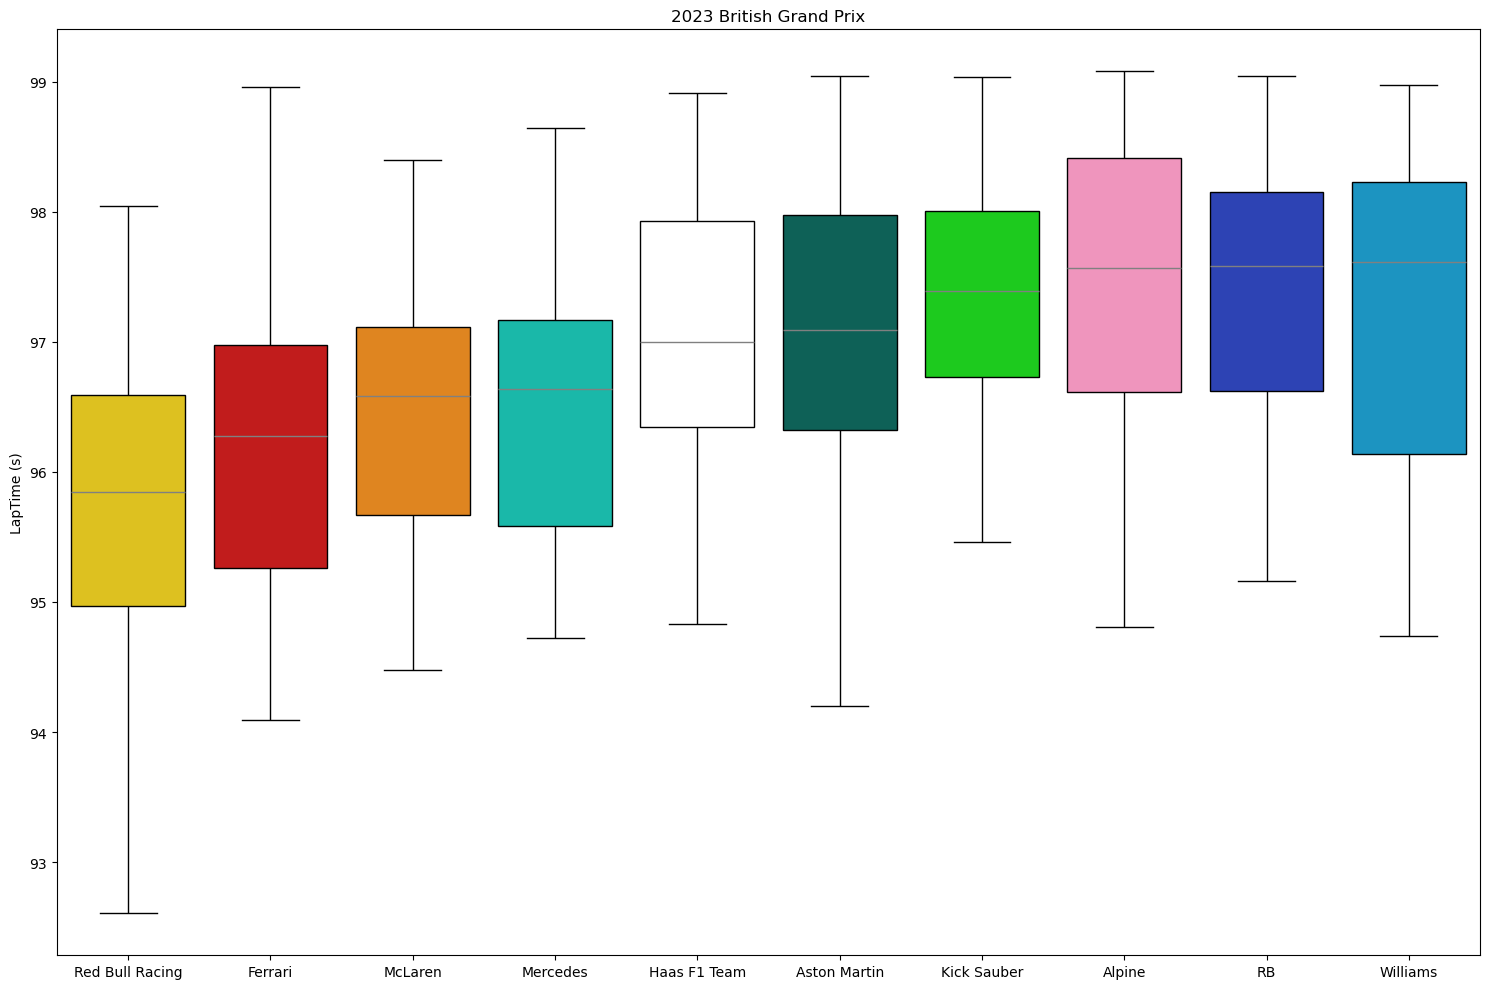

In [8]:
race = fastf1.get_session(2024, 1, 'R')
race.load()
laps = race.laps.pick_quicklaps() # get all laps within 107% of fastest lap
    # use `pick_wo_box()` for races w/ mixed conditions

# Convert the lap time column from timedelta to integer. This is a seaborn-specific modification
transformed_laps = laps.copy()
transformed_laps.loc[:, "LapTime (s)"] = laps["LapTime"].dt.total_seconds()

# order the team from the fastest (lowest median lap time) tp slower
team_order = (
    transformed_laps[["Team", "LapTime (s)"]]
    .groupby("Team")
    .median()["LapTime (s)"]
    .sort_values()
    .index
)
print(team_order)
team_palette = {team: fastf1.plotting.team_color(team) for team in team_order}

fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(
    data=transformed_laps,
    x="Team",
    y="LapTime (s)",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="black"),
    boxprops=dict(edgecolor="black"),
    medianprops=dict(color="grey"),
    capprops=dict(color="black"),
)

plt.title("2023 British Grand Prix")
plt.grid(visible=False)

# x-label is redundant
ax.set(xlabel=None)
plt.tight_layout()
plt.show()

## Position changes during a race

In [8]:
fastf1.plotting.setup_mpl(misc_mpl_mods=False)

session = fastf1.get_session(2023, 1, 'R')
session.load(telemetry=False, weather=False)

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


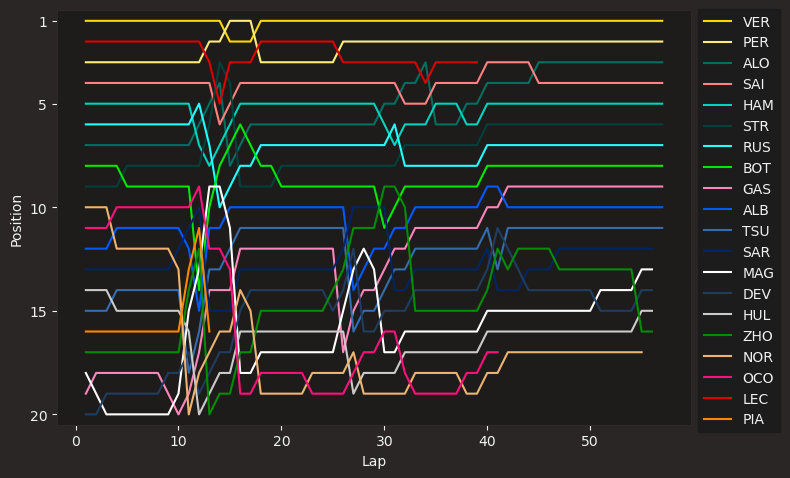

In [21]:
fig, ax = plt.subplots(figsize=(8.0, 4.9))
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')

for drv in session.drivers:
    drv_laps = session.laps.pick_driver(drv)

    abb = drv_laps['Driver'].iloc[0]
    color = fastf1.plotting.driver_color(abb)

    ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
            label=abb, color=color)
    
ax.legend(bbox_to_anchor=(1.0, 1.02))

plt.tight_layout()
plt.show()